In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from resnet1d import Res34SimSiam, Res34SimSiamSplitHeads, Resnet34, Resnet34Baseline, ResBlock
from dataset import Dataset_per_file, Dataset_whole, Dataset_ori
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
import os
import numpy as np
from tqdm import tqdm
import argparse
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import sys
import os
import matplotlib.pyplot as plt
import gc

from collections import OrderedDict

import pacmap
from annoy import AnnoyIndex

import heartpy as hp
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks
import neurokit2 as nk

import matplotlib

layer_keys = ['pool0', 'pool1', 'pool2', 'pool3', 'avgpool']
cecg = '#5d576b'
cppg = '#ed6a5a'
cpeaks = '#17c3b2'
caf = '#ffcb77'
cnaf = '#000000'

In [ ]:
val_dataset = Dataset_whole('/labs/hulab/stark_stuff/ppg_ecg_project/data/', split='val', subset=0)

	loading... val


In [ ]:
# val_subset_dataset = Dataset_whole('/labs/hulab/stark_stuff/ppg_ecg_project/data/', split='val', subset=0)
np.random.seed(1)
subset_idx = np.random.choice(np.arange(len(val_dataset)), replace=False, size=int(len(val_dataset)*0.01))
val_subset_dataset = Subset(val_dataset, subset_idx)
print(len(val_subset_dataset))
# del val_dataset
# gc.collect()

In [ ]:
val_loader = DataLoader(val_subset_dataset, batch_size=2500, shuffle=False, num_workers=0)

In [ ]:
def get_activations(dataloader, model, modules, MODEL_PATH, source='PPG', random_noise=None, reparse_state_dict=True):
    state_dict = torch.load(MODEL_PATH) 
    if reparse_state_dict:
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] #remove 'module'
            new_state_dict[name] = v

        state_dict = new_state_dict
    model.load_state_dict(state_dict)
    model.eval()
    activations = {}
    hooks = {}

    def get_activation(name):

        def hook(model, input, output):
            if not name in activations.keys():
                activations[name] = output.detach().cpu().numpy()
            else:
                activations[name] = np.concatenate((activations[name], output.detach().cpu().numpy()), axis=0)

        return hook
    
    for module in modules:
        for name, layer in module.named_children():
            if 'pool' in name:
                hooks[name] = layer.register_forward_hook(get_activation(name))
    
    labels = None
    
    for batch_idx, (ECG, PPG, target) in enumerate(tqdm(dataloader)):
        
        PPG = PPG.cuda().float()
        ECG = ECG.cuda().float()
        
        if batch_idx == 0:
            labels = target.cpu().numpy()
        else:
            labels = np.concatenate((labels, target.cpu().numpy()))
        
        if source == 'PPG': 
            model(PPG, PPG)
        elif source == 'ECG':
            model(ECG, ECG)
        elif source == 'PPG_peak':
            
            all_ppg_peaks = []
            for ppg in tqdm(PPG.cpu().numpy()):
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            model(PPG_peaks, PPG_peaks)
            
        elif source == 'ECG_R_peak':
#             all_ecg_peaks = []
#             for ecg in tqdm(ECG.cpu().numpy()):
            
#                 ECG_npy = ecg.squeeze()
#                 _, rpeaks  = nk.ecg_peaks(ECG_npy, sampling_rate=80)
#                 _, waves_peak = nk.ecg_delineate(ECG_npy, rpeaks, sampling_rate=80, method="peak")

#                 ECG_peaks = np.zeros_like(ECG_npy)
#                 ECG_peaks[rpeaks['ECG_R_Peaks']] = ECG_npy[rpeaks['ECG_R_Peaks']]
#                 all_ecg_peaks.append(ECG_peaks.reshape((1, ECG_peaks.shape[0])))
#             all_ecg_peaks = np.concatenate(all_ecg_peaks, axis=0)
#             ECG_peaks = torch.from_numpy(all_ecg_peaks).float().unsqueeze(1).cuda()
#             model(ECG_peaks, ECG_peaks)

            all_ppg_peaks = []
            for ppg in tqdm(PPG.cpu().numpy()):
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            model(PPG_peaks, PPG_peaks)
            
        elif source == 'ECG_P_peak':
            all_ecg_peaks = []
            for ecg in tqdm(ECG.cpu().numpy()):
            
                ECG_npy = ecg.squeeze()
                _, rpeaks  = nk.ecg_peaks(ECG_npy, sampling_rate=80)
                _, waves_peak = nk.ecg_delineate(ECG_npy, rpeaks, sampling_rate=80, method="peak")

                ECG_peaks = np.zeros_like(ECG_npy)
                ECG_peaks[waves_peak['ECG_P_Peaks']] = ECG_npy[waves_peak['ECG_P_Peaks']]
                all_ecg_peaks.append(ECG_peaks.reshape((1, ECG_peaks.shape[0])))
            all_ecg_peaks = np.concatenate(all_ecg_peaks, axis=0)
            ECG_peaks = torch.from_numpy(all_ecg_peaks).float().unsqueeze(1).cuda()
            model(ECG_peaks, ECG_peaks)
            
        elif source == 'random_noise':
            assert random_noise is not None
    
            random_noise_batch = random_noise[batch_idx * 2500: min(random_noise.shape[0], (batch_idx+1)* 2500)]
            random_noise_batch = torch.from_numpy(random_noise_batch).float().cuda().unsqueeze(1)
            
            model(random_noise_batch, random_noise_batch)
            
            
        elif source == 'random_peak_pos':
            all_ppg_peaks = []
            for ppg in tqdm(PPG.cpu().numpy()):
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
                
                random_peaklist = np.random.choice(range(2400), len(wd['peaklist']), replace=False)
                PPG_peaks[random_peaklist] = wd['ybeat']
                
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            model(PPG_peaks, PPG_peaks)
            

        elif source == 'random_peak_vals':
            
            all_ppg_peaks = []
            for ppg in tqdm(PPG.cpu().numpy()):
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
                
                random_ybeat = np.random.randn(len(wd['peaklist']))
                random_ybeat = (random_ybeat - random_ybeat.min()) / (random_ybeat.max() - random_ybeat.min())
                PPG_peaks[wd['peaklist']] = random_ybeat
                
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            model(PPG_peaks, PPG_peaks)
            
        
        elif source == 'random_peak_all':
            all_ppg_peaks = []
            for ppg in tqdm(PPG.cpu().numpy()):
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
                
                random_ybeat = np.random.randn(len(wd['peaklist']))
                random_ybeat = (random_ybeat - random_ybeat.min()) / (random_ybeat.max() - random_ybeat.min())
                random_peaklist = np.random.choice(range(2400), len(wd['peaklist']), replace=False)

                PPG_peaks[random_peaklist] = random_ybeat
                
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            model(PPG_peaks, PPG_peaks)
                
            
            
            
    for h in hooks.values(): h.remove()
        
    del model, state_dict, hooks
    gc.collect()
        
    return activations, labels

# SimSiam

In [6]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/corrected_resnet_34_epoch_30_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128_pred_True_bs=5000/model_1.pt'

In [7]:
model = Res34SimSiam(512, 128, single_source_mode=True).cuda()

In [8]:
PPG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG')
ECG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='ECG')

100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


In [9]:
np.save('val_latent_activation_npys/labels.npy', labels)

In [10]:
labels = np.load('val_latent_activation_npys/labels.npy')

In [13]:
PPG_peak_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG_peak')

100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


In [14]:
for key in PPG_activations.keys():
    activation = np.concatenate((PPG_activations[key], ECG_activations[key]), axis=0)
    activation = np.concatenate((activation, PPG_peak_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(83574, 6960)
pool0 (83574, 2)
(83574, 1728)
pool1 (83574, 2)
(83574, 864)
pool2 (83574, 2)
(83574, 384)
pool3 (83574, 2)
(83574, 768)
avgpool (83574, 2)


pool0 (83574, 2)
pool1 (83574, 2)
pool2 (83574, 2)
pool3 (83574, 2)
avgpool (83574, 2)


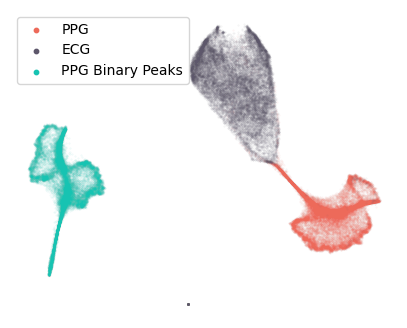

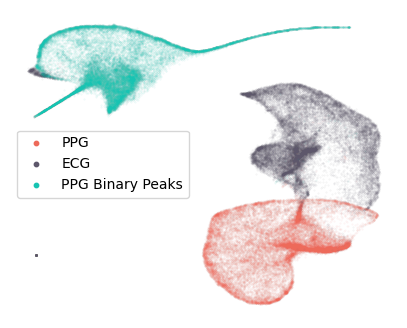

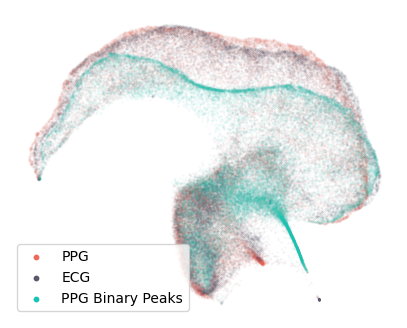

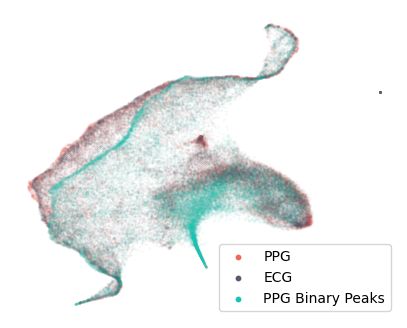

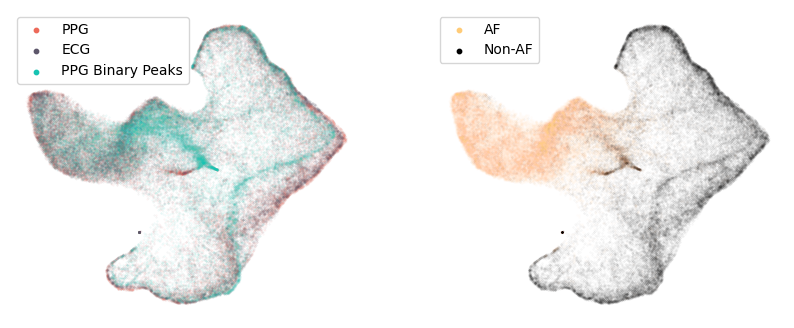

In [11]:
for idx, key in enumerate(layer_keys):
# for key in :
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy')
    print(key, X_transformed.shape)
    
#     if idx != len(PPG_activations.keys()) - 1:
    
#         fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
#         ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
#         ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
#         ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color='tab:purple')
#         ax0.axis('off')
        
#         leg0 = ax0.legend(numpoints=10)
#         for lh in leg0.legendHandles: 
#             lh.set_alpha(1)
#             lh._sizes = [10]
#     else:
#         fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
#         ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
#         ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
#         ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color='tab:purple')

#         leg0 = ax0.legend(numpoints=10)
#         for lh in leg0.legendHandles: 
#             lh.set_alpha(1)
#             lh._sizes = [10]
#         ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
#         ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==1], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='', color='r')
#         ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==1], X_transformed[:, 1][2*labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')

#         ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
#         ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==0], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color='g')
#         ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==0], X_transformed[:, 1][2*labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color='g')
#         ax0.axis('off')
#         ax1.axis('off')

    if idx != len(layer_keys) - 1:
    
        fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)
        ax0.axis('off')
        
        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color=caf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==1], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='', color=caf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==1], X_transformed[:, 1][2*labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color=caf)

        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color=cnaf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==0], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==0], X_transformed[:, 1][2*labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax0.axis('off')
        ax1.axis('off')
        
        leg1 = ax1.legend(numpoints=10)
        for lh in leg1.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        
#     ax0.set_title(f'{key} layer activations (ECG and PPG)')
#     ax1.set_title(f'{key} layer activations (AF and Non-AF)')
#     plt.show()
    
    plt.savefig(f'latent_vizs/simsiam_{key}.png', dpi=300)

# PPG/ECG only combined

In [6]:
MODEL_PATH_baseline_PPG = '/home/zguo30/ppg_ecg_proj/ppg_only_baseline/saved_models/corrected_res34_epoch_30_ppglr_0.0001_lambda_0.9_bs=5000/PPG_best_5.pt'
PPG_model = Resnet34Baseline().cuda()
MODEL_PATH_baseline_ECG = '/home/zguo30/ppg_ecg_proj/ecg_only_baseline/saved_models/corrected_epoch_30_ecglr_0.0001_lambda_0.9/ECG_best_5.pt'
ECG_model = Resnet34Baseline().cuda()

In [8]:
PPG_baseline_activations, labels = get_activations(val_loader, PPG_model, [PPG_model], MODEL_PATH_baseline_PPG, source='PPG', reparse_state_dict=True)
ECG_baseline_activations, labels = get_activations(val_loader, ECG_model, [ECG_model], MODEL_PATH_baseline_ECG, source='ECG', reparse_state_dict=False)
PPG_peak_activations, labels = get_activations(val_loader, PPG_model, [PPG_model], MODEL_PATH_baseline_PPG, source='PPG_peak', reparse_state_dict=True)

100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


In [9]:
for key in PPG_baseline_activations.keys():
    activation = np.concatenate((PPG_baseline_activations[key], ECG_baseline_activations[key]), axis=0)
    activation = np.concatenate((activation, PPG_peak_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_ppgecgonlybaselinecombined_peaks.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(83574, 6960)
pool0 (83574, 2)
(83574, 1728)
pool1 (83574, 2)
(83574, 864)
pool2 (83574, 2)
(83574, 384)
pool3 (83574, 2)
(83574, 768)
avgpool (83574, 2)


pool0 (83574, 2)
pool1 (83574, 2)
pool2 (83574, 2)
pool3 (83574, 2)
avgpool (83574, 2)


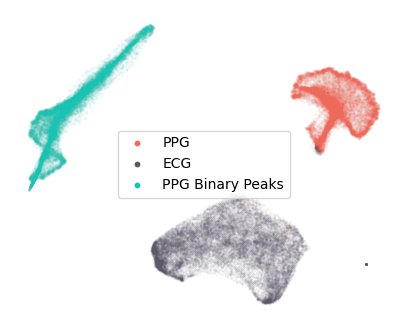

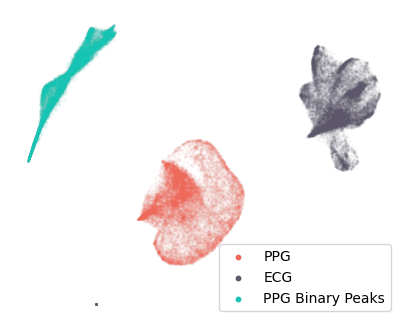

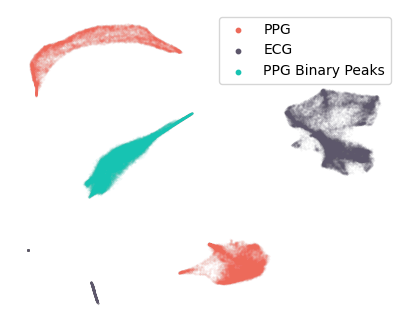

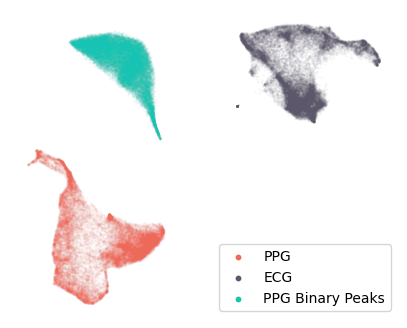

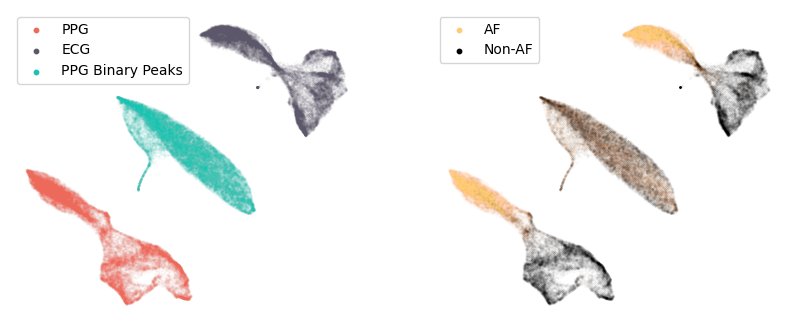

In [12]:
for idx, key in enumerate(layer_keys):
# for key in ['pool0', 'pool1', 'pool2', 'pool3', 'avgpool']:
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppgecgonlybaselinecombined_peaks.npy')
    print(key, X_transformed.shape)
    
    if idx != len(layer_keys) - 1:
    
        fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)
        ax0.axis('off')
        
        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color=caf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==1], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='', color=caf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==1], X_transformed[:, 1][2*labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color=caf)

        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color=cnaf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==0], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==0], X_transformed[:, 1][2*labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax0.axis('off')
        ax1.axis('off')
        
        leg1 = ax1.legend(numpoints=10)
        for lh in leg1.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        
#     ax0.set_title(f'{key} layer activations (ECG and PPG)')
#     ax1.set_title(f'{key} layer activations (AF and Non-AF)')
#     plt.show()
    
    plt.savefig(f'latent_vizs/ppgecgcombined_{key}.png', dpi=300)

# Deep MI combined

In [13]:
MODEL_PATH_deepmi_PPG = '/home/zguo30/ppg_ecg_proj/deepmi/saved_models/corrected_epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_0.9/PPG_best_5.pt'
PPG_model = Resnet34Baseline().cuda()
MODEL_PATH_deepmi_ECG = '/home/zguo30/ppg_ecg_proj/deepmi/saved_models/corrected_epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_0.9/ECG_best_5.pt'
ECG_model = Resnet34Baseline().cuda()

In [14]:
PPG_deepmi_activations, labels = get_activations(val_loader, PPG_model, [PPG_model], MODEL_PATH_deepmi_PPG, source='PPG', reparse_state_dict=True)
ECG_deepmi_activations, labels = get_activations(val_loader, ECG_model, [ECG_model], MODEL_PATH_deepmi_ECG, source='ECG', reparse_state_dict=True)
PPG_peak_activations, labels = get_activations(val_loader, PPG_model, [PPG_model], MODEL_PATH_baseline_PPG, source='PPG_peak', reparse_state_dict=True)

100%|██████████| 12/12 [00:21<00:00,  1.75s/it]


In [15]:
for key in PPG_deepmi_activations.keys():
    activation = np.concatenate((PPG_deepmi_activations[key], ECG_deepmi_activations[key]), axis=0)
    activation = np.concatenate((activation, PPG_peak_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_deepmicombined_peaks.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(83574, 6960)
pool0 (83574, 2)
(83574, 1728)
pool1 (83574, 2)
(83574, 864)
pool2 (83574, 2)
(83574, 384)
pool3 (83574, 2)
(83574, 768)
avgpool (83574, 2)


pool0 (83574, 2)
pool1 (83574, 2)
pool2 (83574, 2)
pool3 (83574, 2)
avgpool (83574, 2)


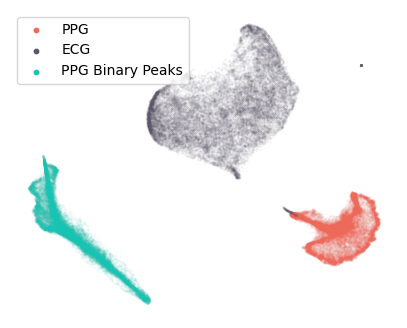

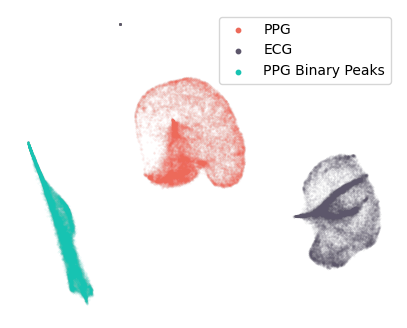

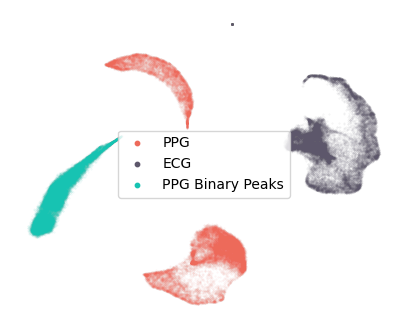

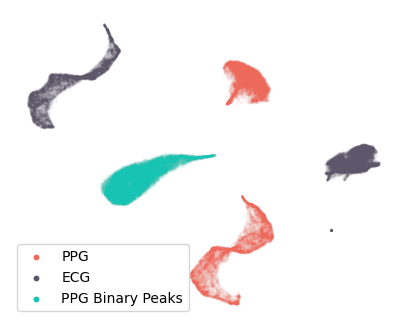

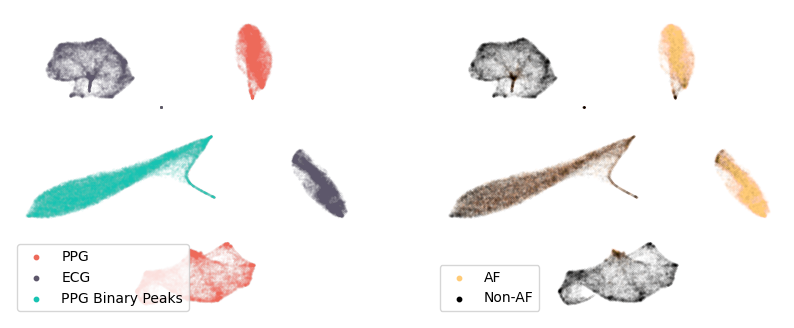

In [13]:
for idx, key in enumerate(layer_keys):
# for key in ['pool0', 'pool1', 'pool2', 'pool3', 'avgpool']:
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_deepmicombined_peaks.npy')
    print(key, X_transformed.shape)
    if idx != len(layer_keys) - 1:
    
        fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)
        ax0.axis('off')
        
        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG', color=cppg)
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG', color=cecg)
        ax0.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='PPG Binary Peaks', color=cpeaks)

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color=caf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==1], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='', color=caf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==1], X_transformed[:, 1][2*labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color=caf)

        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color=cnaf)
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==0], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==0], X_transformed[:, 1][2*labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color=cnaf)
        ax0.axis('off')
        ax1.axis('off')
        
        leg1 = ax1.legend(numpoints=10)
        for lh in leg1.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        
#     ax0.set_title(f'{key} layer activations (ECG and PPG)')
#     ax1.set_title(f'{key} layer activations (AF and Non-AF)')
#     plt.show()
    
    plt.savefig(f'latent_vizs/deepmicombined_{key}.png', dpi=300)

# PPG Only Baseline

In [41]:
MODEL_PATH_baseline = '/home/zguo30/ppg_ecg_proj/ppg_only_baseline/saved_models/corrected_res34_epoch_30_ppglr_0.0001_lambda_0.9_bs=5000/PPG_best_5.pt'
model = Resnet34Baseline().cuda()

In [43]:
PPG_baseline_activations, labels = get_activations(val_loader, model, [model], MODEL_PATH_baseline, source='PPG', reparse_state_dict=True)

100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


In [45]:
PPG_peak_activations, labels = get_activations(val_loader, model, [model], MODEL_PATH_baseline, source='PPG_peak', reparse_state_dict=True)

100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


In [46]:
for key in PPG_baseline_activations.keys():
    activation = np.concatenate((PPG_baseline_activations[key], PPG_peak_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks_ppgonly_baseline.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(55716, 6960)
pool0 (55716, 2)
(55716, 1728)
pool1 (55716, 2)
(55716, 864)
pool2 (55716, 2)
(55716, 384)
pool3 (55716, 2)
(55716, 768)
avgpool (55716, 2)


pool0 (55716, 2)
pool1 (55716, 2)
pool2 (55716, 2)
pool3 (55716, 2)
avgpool (55716, 2)


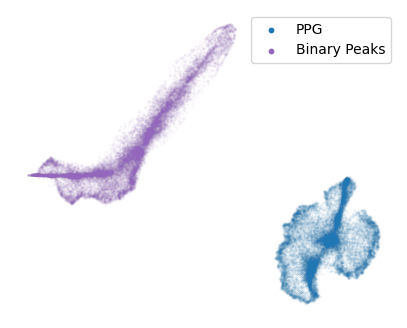

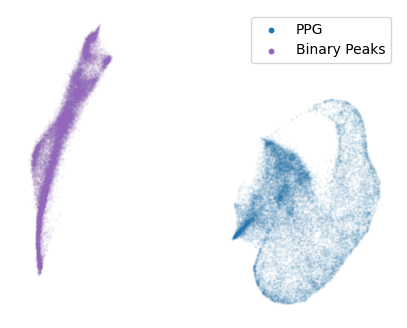

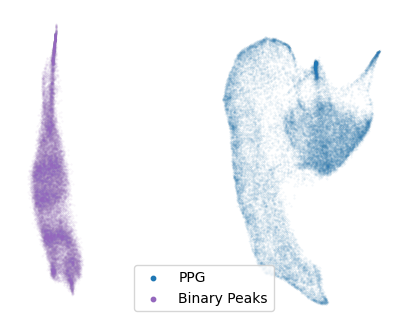

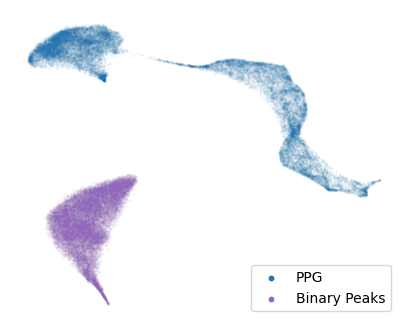

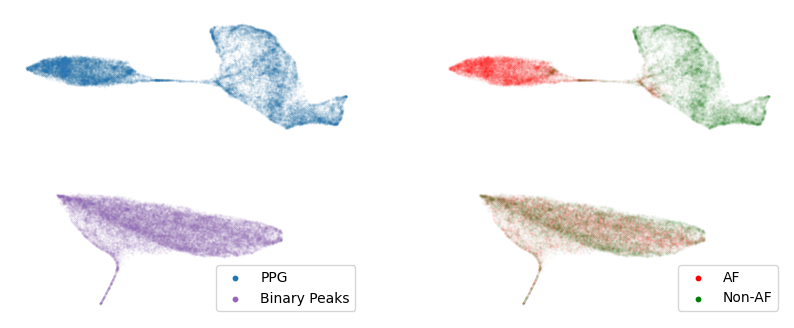

In [49]:
for idx, key in enumerate(PPG_baseline_activations.keys()):
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks_ppgonly_baseline.npy')
    print(key, X_transformed.shape)
    if idx != len(PPG_activations.keys()) - 1:
        fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='Binary Peaks', color='tab:purple')

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax0.axis('off')
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='Binary Peaks', color='tab:purple')

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==1], X_transformed[:, 1][labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')

        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==0], X_transformed[:, 1][labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color='g')

        leg1 = ax1.legend(numpoints=10)
        for lh in leg1.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax0.axis('off')
        ax1.axis('off')
        
#     ax0.set_title(f'{key} layer activations (PPG)')
#     ax1.set_title(f'{key} layer activations (AF and Non-AF)')
#     plt.show()
    
    plt.savefig(f'latent_vizs/ppgbase_{key}.png', dpi=300)

# Deep MI PPG

In [50]:
MODEL_PATH_deepmi = '/home/zguo30/ppg_ecg_proj/deepmi/saved_models/corrected_epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_0.9/PPG_best_5.pt'
model = Resnet34Baseline().cuda()

In [51]:
PPG_deepmi_activations, labels = get_activations(val_loader, model, [model], MODEL_PATH_deepmi, source='PPG', reparse_state_dict=True)

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


In [52]:
PPG_peak_activations, labels = get_activations(val_loader, model, [model], MODEL_PATH_deepmi, source='PPG_peak', reparse_state_dict=True)

100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


In [54]:
for key in PPG_deepmi_activations.keys():
    activation = np.concatenate((PPG_deepmi_activations[key], PPG_peak_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks_ppg_deepmi.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(55716, 6960)
pool0 (55716, 2)
(55716, 1728)
pool1 (55716, 2)
(55716, 864)
pool2 (55716, 2)
(55716, 384)
pool3 (55716, 2)
(55716, 768)
avgpool (55716, 2)


pool0 (55716, 2)
pool1 (55716, 2)
pool2 (55716, 2)
pool3 (55716, 2)
avgpool (55716, 2)


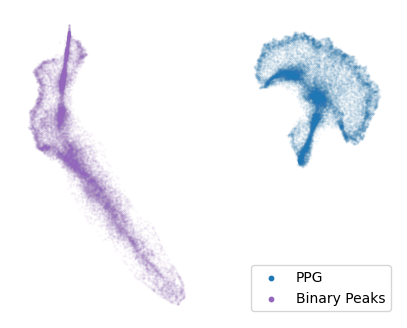

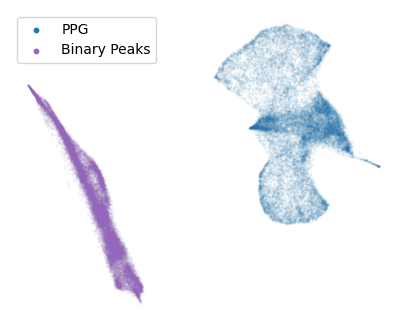

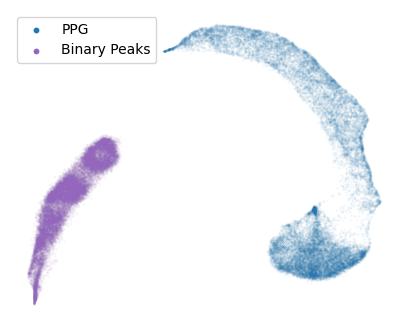

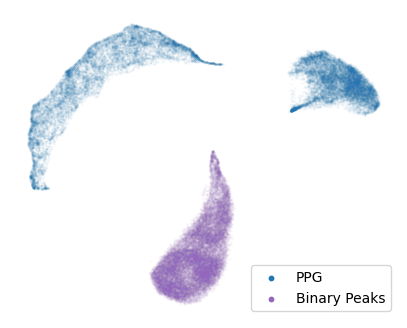

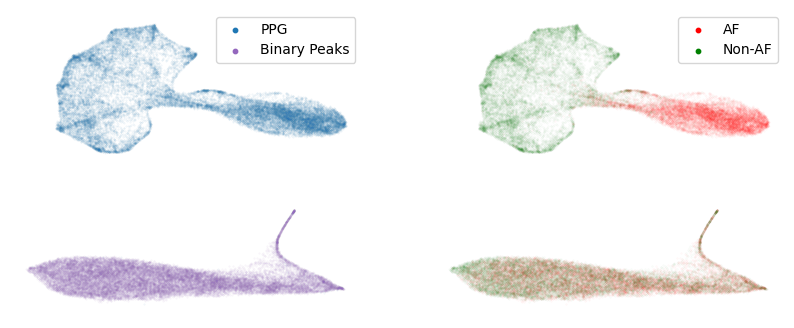

In [55]:
for idx, key in enumerate(PPG_deepmi_activations.keys()):
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks_ppg_deepmi.npy')
    print(key, X_transformed.shape)
    if idx != len(PPG_activations.keys()) - 1:
        fig, ax0 = plt.subplots(1, 1, figsize=(5, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='Binary Peaks', color='tab:purple')

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax0.axis('off')
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
        ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
        ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='Binary Peaks', color='tab:purple')

        leg0 = ax0.legend(numpoints=10)
        for lh in leg0.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==1], X_transformed[:, 1][labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')

        ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
        ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==0], X_transformed[:, 1][labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color='g')

        leg1 = ax1.legend(numpoints=10)
        for lh in leg1.legendHandles: 
            lh.set_alpha(1)
            lh._sizes = [10]
        ax0.axis('off')
        ax1.axis('off')
        
#     ax0.set_title(f'{key} layer activations (PPG)')
#     ax1.set_title(f'{key} layer activations (AF and Non-AF)')
#     plt.show()
    
    plt.savefig(f'latent_vizs/ppgdeepmi_{key}.png', dpi=300)

# Compare projections to random noises

In [113]:
np.random.seed(1)
random_noises = np.random.rand(len(val_subset_dataset), 2400)
print(random_noises.shape)

(27858, 2400)


In [114]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128/model_1.pt'
model = Res34SimSiam(512, 128, single_source_mode=True).cuda()

In [116]:
PPG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG')
ECG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='ECG')
random_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='random_noise', random_noise=random_noises)

100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


In [117]:
for key in PPG_activations.keys():
    activation = np.concatenate((PPG_activations[key], ECG_activations[key]), axis=0)
    activation = np.concatenate((activation, random_activations[key]), axis=0)
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_randoms.npy', X_transformed)
    
    print(key, X_transformed.shape)

(83574, 6960)
pool0 (83574, 2)
(83574, 1728)
pool1 (83574, 2)
(83574, 864)
pool2 (83574, 2)
(83574, 384)
pool3 (83574, 2)
(83574, 768)
avgpool (83574, 2)


pool0 (83574, 2)


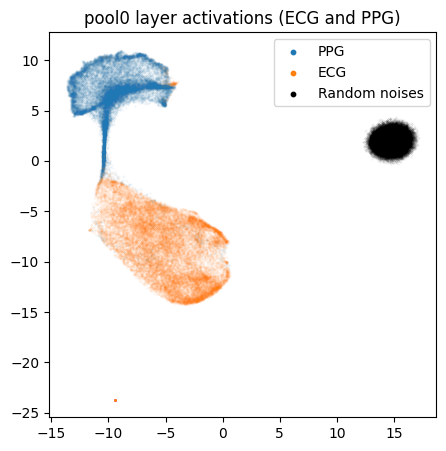

pool1 (83574, 2)


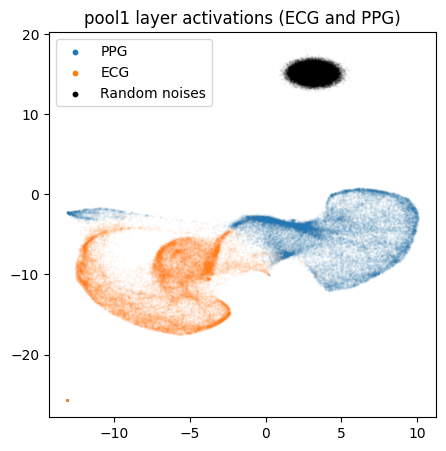

pool2 (83574, 2)


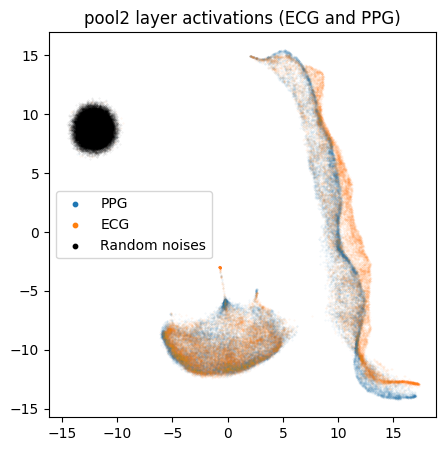

pool3 (83574, 2)


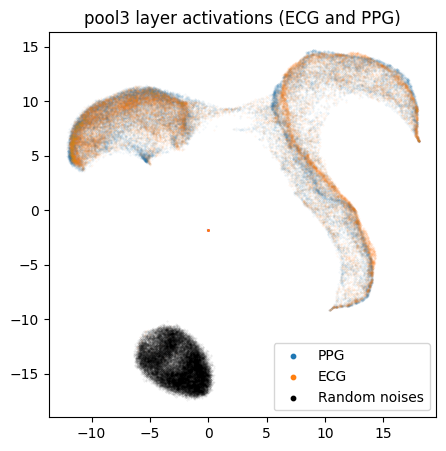

avgpool (83574, 2)


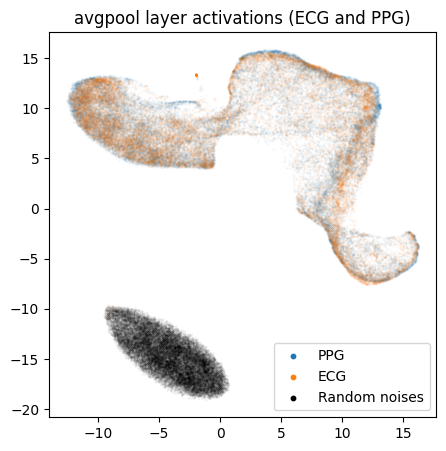

In [124]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_randoms.npy')
    print(key, X_transformed.shape)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
    ax.scatter(X_transformed[:, 0][2*labels.shape[0]:], X_transformed[:, 1][2*labels.shape[0]:], alpha=0.1, s=0.1, label='Random noises', color='black')
    
    leg0 = ax.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]

#     ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
#     ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==1], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='', color='r')
#     ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==1], X_transformed[:, 1][2*labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')
    
#     ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
#     ax1.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][labels==0], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color='g')
#     ax1.scatter(X_transformed[:, 0][2*labels.shape[0]:][labels==0], X_transformed[:, 1][2*labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='', color='g')

#     leg1 = ax1.legend(numpoints=10)
#     for lh in leg1.legendHandles: 
#         lh.set_alpha(1)
#         lh._sizes = [10]
        
    plt.title(f'{key} layer activations (ECG and PPG)')
    plt.show()

# More realistic random peaks 

In [27]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128/model_1.pt'
model = Res34SimSiam(512, 128, single_source_mode=True).cuda()

In [28]:
PPG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG')
ECG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='ECG')

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


In [29]:
PPG_activations_random_peak_pos, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='random_peak_pos')
PPG_activations_random_peak_vals, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='random_peak_vals')
PPG_activations_random_peak_all, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='random_peak_all')

 67%|██████▋   | 1678/2500 [00:01<00:00, 1511.45it/s]


100%|██████████| 2500/2500 [00:02<00:00, 1007.24it/s]


100%|██████████| 12/12 [00:37<00:00,  3.13s/it]


In [36]:
PPG_peak_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG_peak')

100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


In [ ]:
for key in PPG_activations.keys():
    activation = np.concatenate((PPG_activations[key], ECG_activations[key]), axis=0)
    activation = np.concatenate((activation, PPG_activations_random_peak_pos[key]), axis=0)
    activation = np.concatenate((activation, PPG_activations_random_peak_vals[key]), axis=0)
    activation = np.concatenate((activation, PPG_activations_random_peak_all[key]), axis=0)
    activation = np.concatenate((activation, PPG_peak_activations[key]), axis=0)
    
    
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_realistic_random_peaks_mix.npy', X_transformed)
    
    print(key, X_transformed.shape)

(250722, 6960)


pool0 (250722, 2)


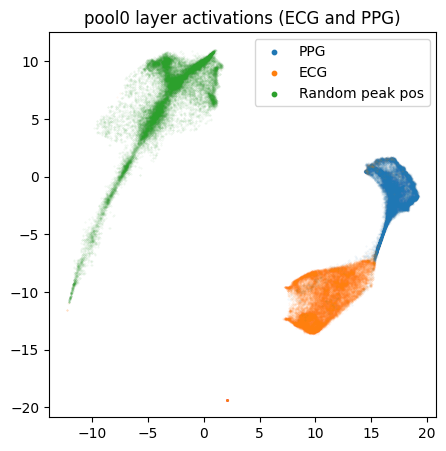

pool1 (250722, 2)


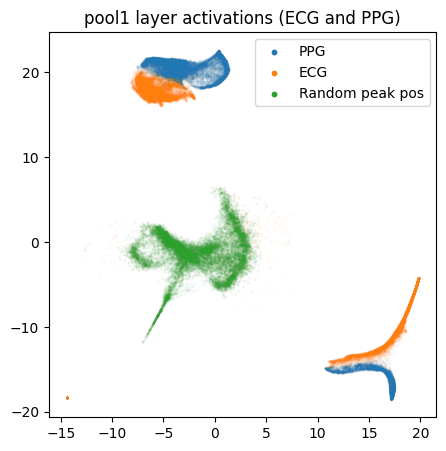

pool2 (250722, 2)


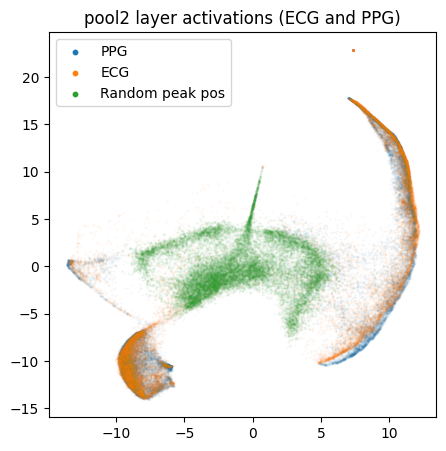

pool3 (250722, 2)


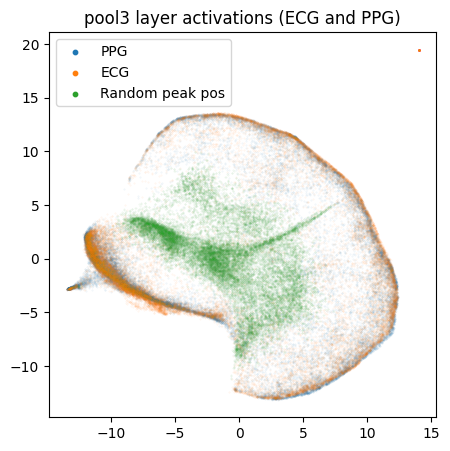

avgpool (250722, 2)


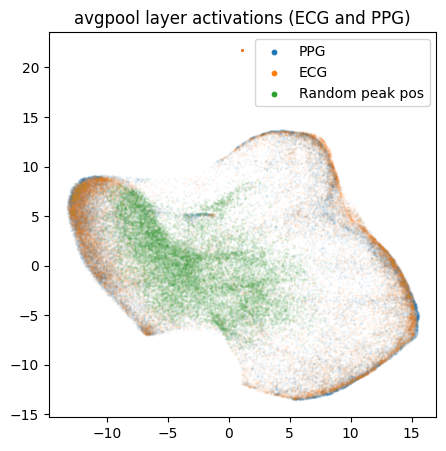

In [38]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_realistic_random_peaks_mix.npy')
    print(key, X_transformed.shape)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
    ax.scatter(X_transformed[:, 0][2*labels.shape[0]:3*labels.shape[0]], X_transformed[:, 1][2*labels.shape[0]:3*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak pos')
#     ax.scatter(X_transformed[:, 0][3*labels.shape[0]:4*labels.shape[0]], X_transformed[:, 1][3*labels.shape[0]:4*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak vals')
#     ax.scatter(X_transformed[:, 0][4*labels.shape[0]:5*labels.shape[0]], X_transformed[:, 1][4*labels.shape[0]:5*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak all')
    
    
    leg0 = ax.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    plt.title(f'{key} layer activations (ECG and PPG)')
    plt.show()

pool0 (250722, 2)


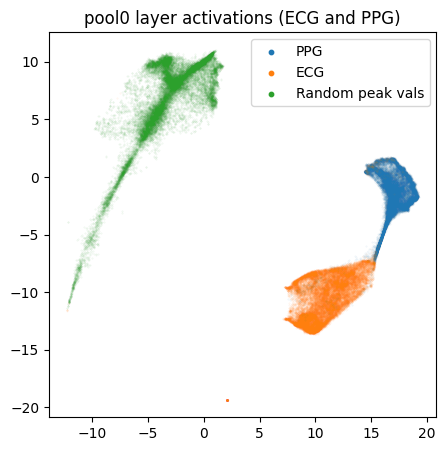

pool1 (250722, 2)


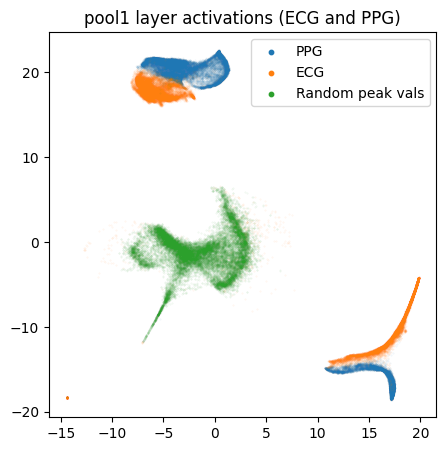

pool2 (250722, 2)


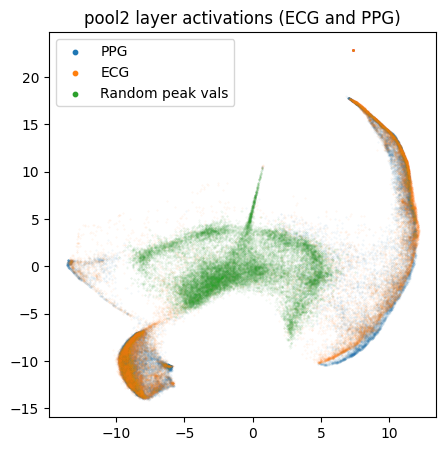

pool3 (250722, 2)


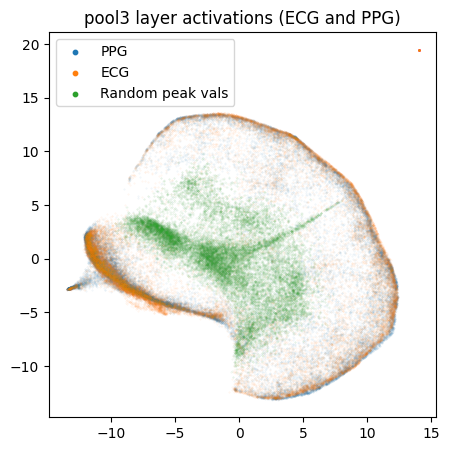

avgpool (250722, 2)


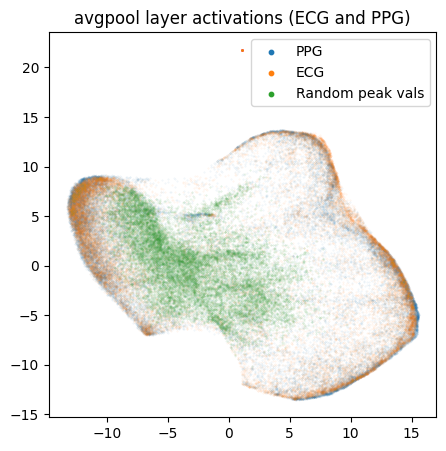

In [39]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_realistic_random_peaks_mix.npy')
    print(key, X_transformed.shape)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
#     ax.scatter(X_transformed[:, 0][2*labels.shape[0]:3*labels.shape[0]], X_transformed[:, 1][2*labels.shape[0]:3*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak pos')
    ax.scatter(X_transformed[:, 0][3*labels.shape[0]:4*labels.shape[0]], X_transformed[:, 1][3*labels.shape[0]:4*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak vals')
#     ax.scatter(X_transformed[:, 0][4*labels.shape[0]:5*labels.shape[0]], X_transformed[:, 1][4*labels.shape[0]:5*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak all')
    
    
    
    leg0 = ax.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    plt.title(f'{key} layer activations (ECG and PPG)')
    plt.show()

pool0 (250722, 2)


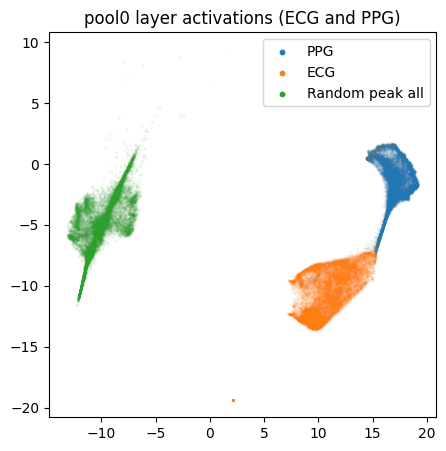

pool1 (250722, 2)


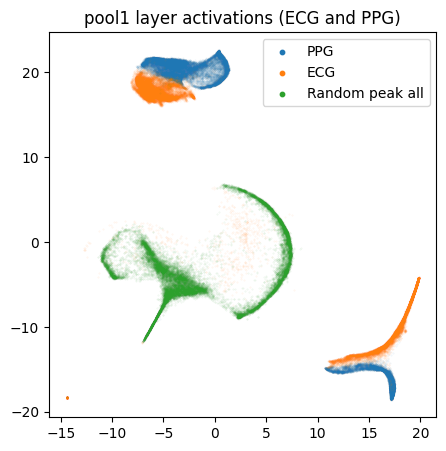

pool2 (250722, 2)


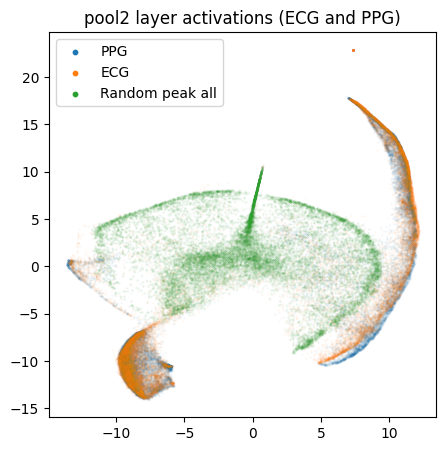

pool3 (250722, 2)


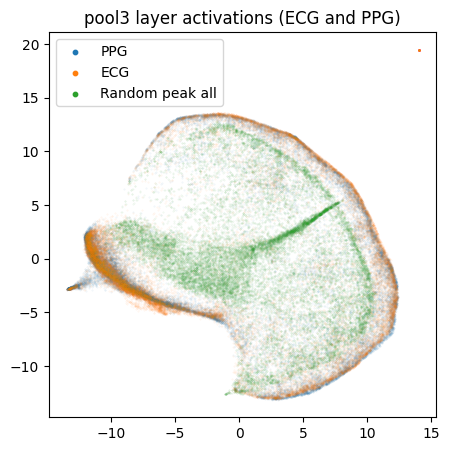

avgpool (250722, 2)


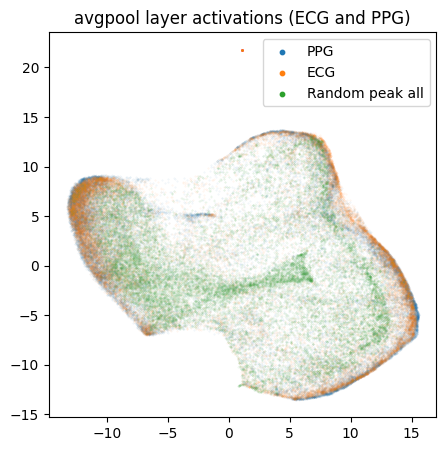

In [40]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_realistic_random_peaks_mix.npy')
    print(key, X_transformed.shape)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
#     ax.scatter(X_transformed[:, 0][2*labels.shape[0]:3*labels.shape[0]], X_transformed[:, 1][2*labels.shape[0]:3*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak pos')
#     ax.scatter(X_transformed[:, 0][3*labels.shape[0]:4*labels.shape[0]], X_transformed[:, 1][3*labels.shape[0]:4*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak vals')
    ax.scatter(X_transformed[:, 0][4*labels.shape[0]:5*labels.shape[0]], X_transformed[:, 1][4*labels.shape[0]:5*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak all')
    
    
    
    leg0 = ax.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    plt.title(f'{key} layer activations (ECG and PPG)')
    plt.show()

pool0 (222864, 2)


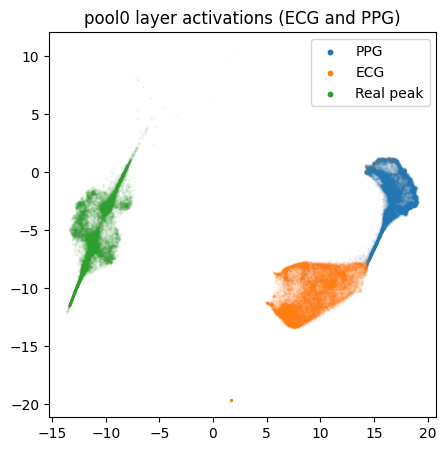

pool1 (222864, 2)


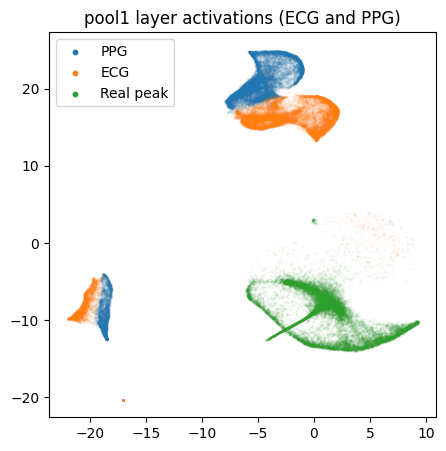

pool2 (222864, 2)


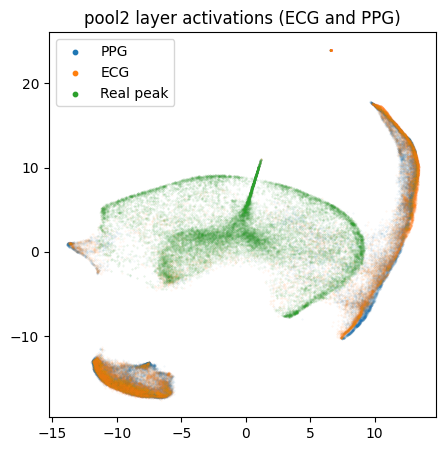

pool3 (222864, 2)


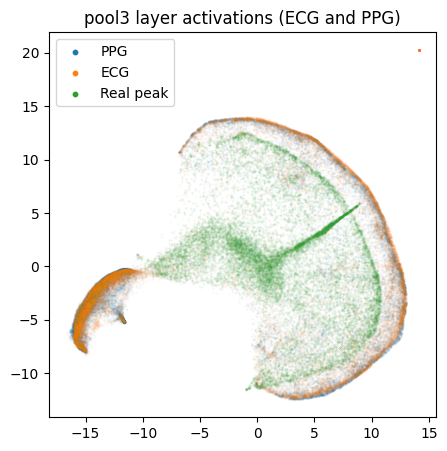

avgpool (222864, 2)


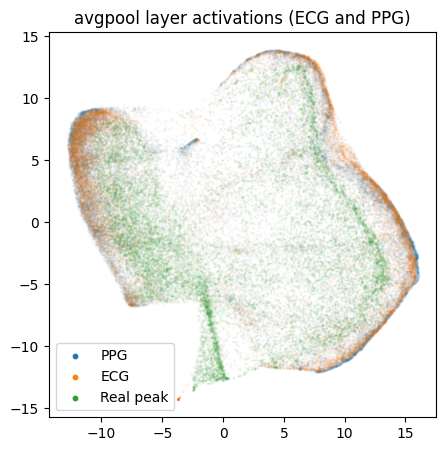

In [45]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_realistic_random_peaks.npy')
    print(key, X_transformed.shape)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]], alpha=0.1, s=0.1, label='ECG')
#     ax.scatter(X_transformed[:, 0][2*labels.shape[0]:3*labels.shape[0]], X_transformed[:, 1][2*labels.shape[0]:3*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak pos')
#     ax.scatter(X_transformed[:, 0][3*labels.shape[0]:4*labels.shape[0]], X_transformed[:, 1][3*labels.shape[0]:4*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak vals')
#     ax.scatter(X_transformed[:, 0][4*labels.shape[0]:5*labels.shape[0]], X_transformed[:, 1][4*labels.shape[0]:5*labels.shape[0]], alpha=0.1, s=0.1, label='Random peak all')
    ax.scatter(X_transformed[:, 0][5*labels.shape[0]:6*labels.shape[0]], X_transformed[:, 1][5*labels.shape[0]:6*labels.shape[0]], alpha=0.1, s=0.1, label='Real peak')
    
    
    leg0 = ax.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    plt.title(f'{key} layer activations (ECG and PPG)')
    plt.show()

# Projection position validations

pool0


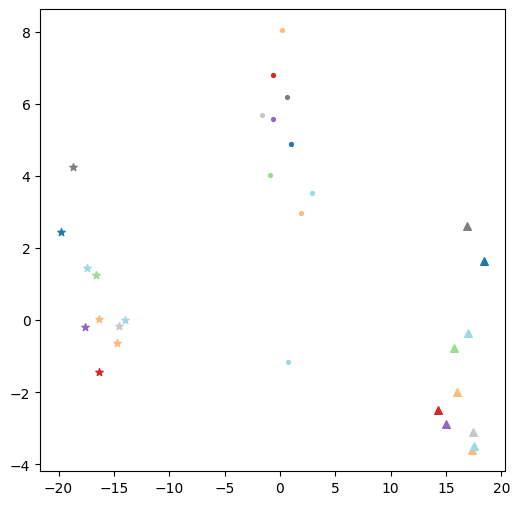

pool1


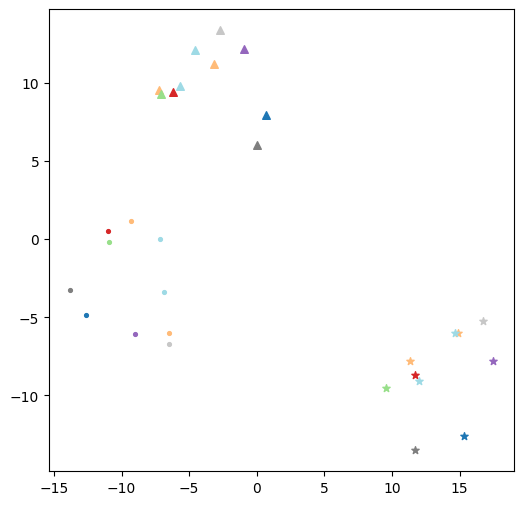

pool2


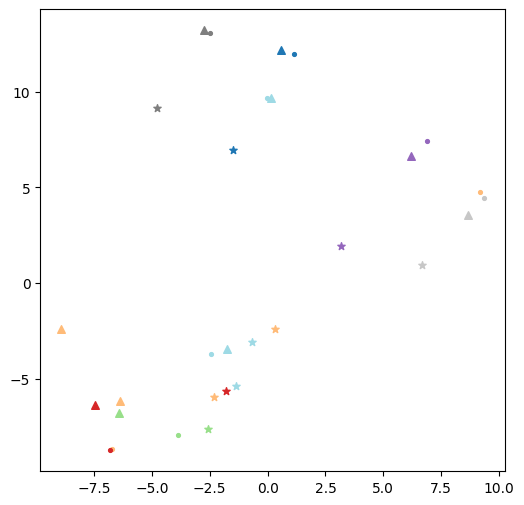

pool3


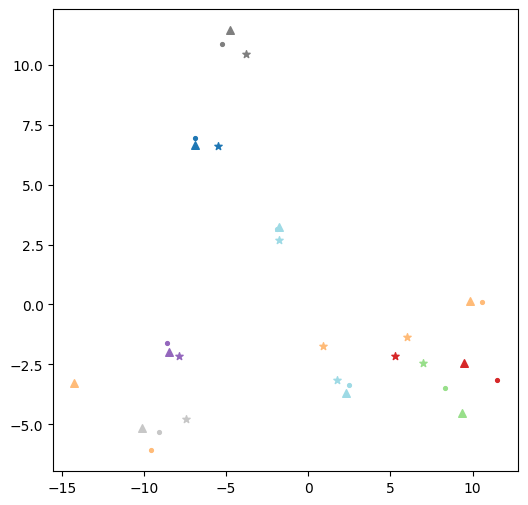

avgpool


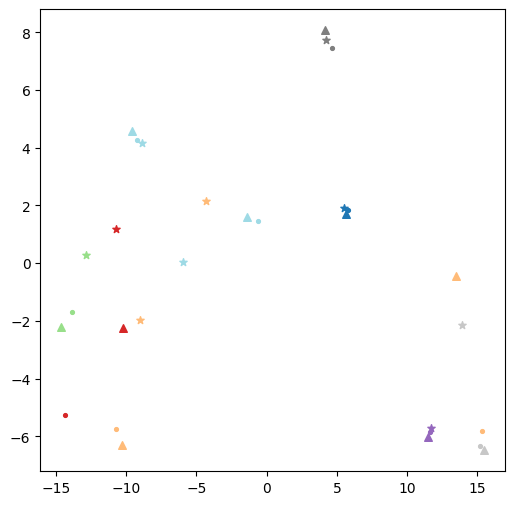

In [79]:
subset_idx_for_positions_size = 10
subset_idx_for_positions = np.random.choice(np.arange(len(labels)), replace=False, size=subset_idx_for_positions_size)
cmap = matplotlib.cm.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=min(subset_idx_for_positions), vmax=max(subset_idx_for_positions))
S = 30
A = 1
for key in PPG_activations.keys():
    fig = plt.figure(figsize=(6, 6))
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy')
    print(key)    
    for idx in sorted(subset_idx_for_positions):
        color = cmap(norm(idx))
        plt.scatter(X_transformed[:, 0][:labels.shape[0]][idx], X_transformed[:, 1][:labels.shape[0]][idx], color=color, marker='^', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][idx], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][idx], color=color, marker='.', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][2*labels.shape[0]:][idx], X_transformed[:, 1][2*labels.shape[0]:][idx], color=color, marker='*', s=S, alpha=A)
        

    plt.show()

pool0


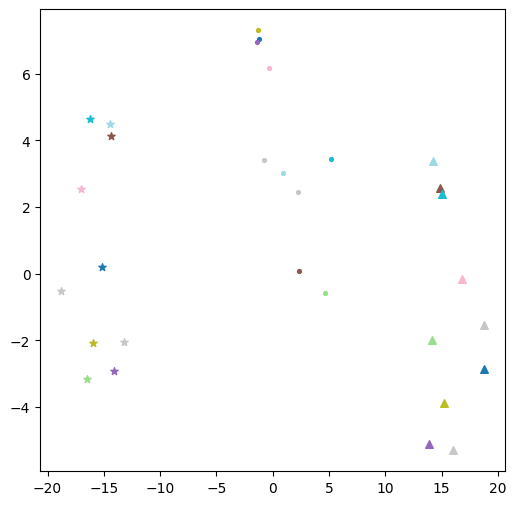

pool1


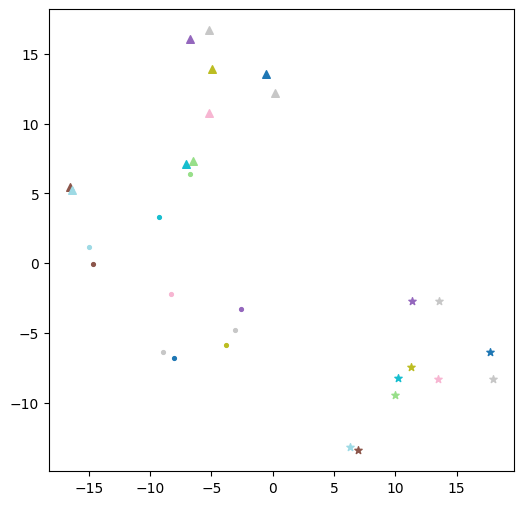

pool2


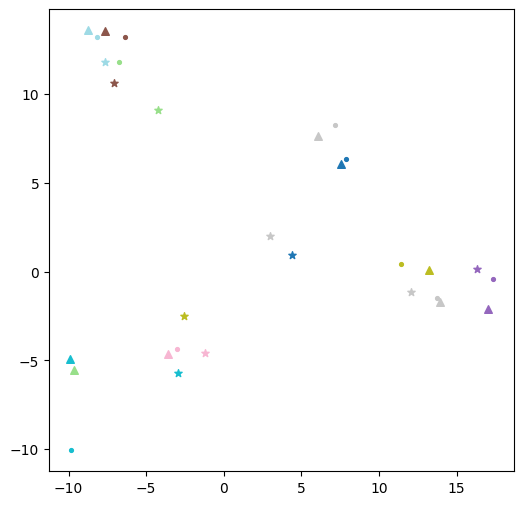

pool3


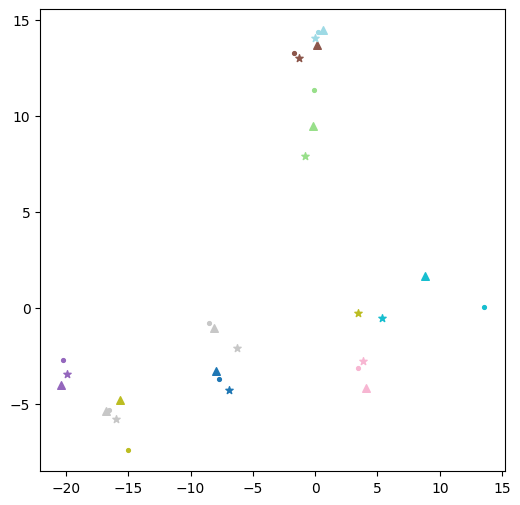

avgpool


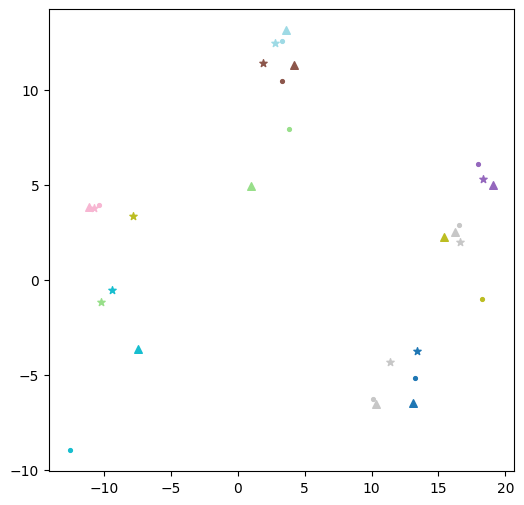

In [80]:
np.random.seed(10)
subset_idx_for_positions_size = 10
subset_idx_for_positions = np.random.choice(np.arange(len(labels)), replace=False, size=subset_idx_for_positions_size)
cmap = matplotlib.cm.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=min(subset_idx_for_positions), vmax=max(subset_idx_for_positions))
S = 30
A = 1
for key in PPG_activations.keys():
    fig = plt.figure(figsize=(6, 6))
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy')
    print(key)    
    for idx in sorted(subset_idx_for_positions):
        color = cmap(norm(idx))
        plt.scatter(X_transformed[:, 0][:labels.shape[0]][idx], X_transformed[:, 1][:labels.shape[0]][idx], color=color, marker='^', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][idx], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][idx], color=color, marker='.', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][2*labels.shape[0]:][idx], X_transformed[:, 1][2*labels.shape[0]:][idx], color=color, marker='*', s=S, alpha=A)
        

    plt.show()

pool0


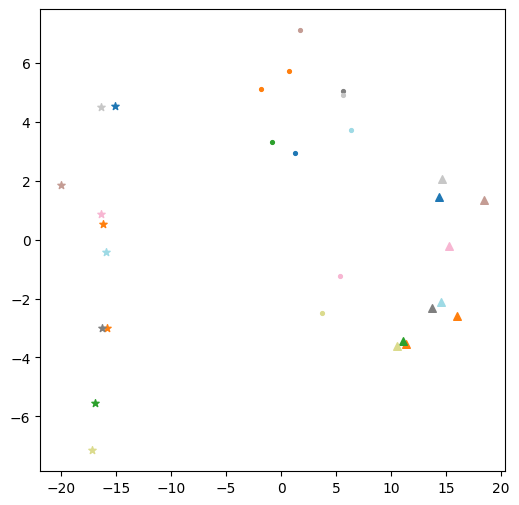

pool1


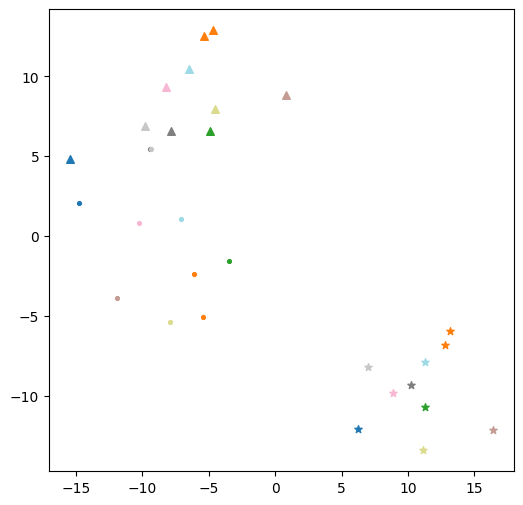

pool2


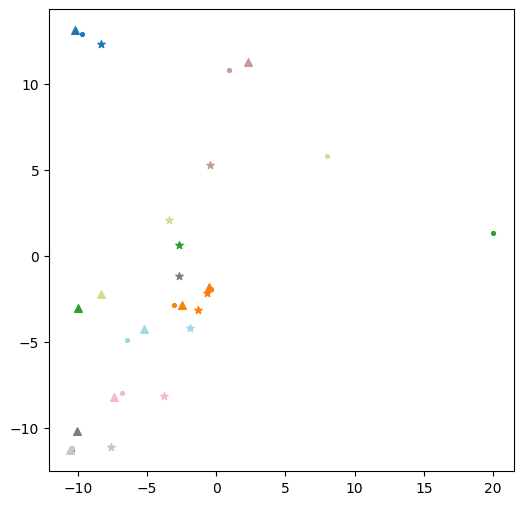

pool3


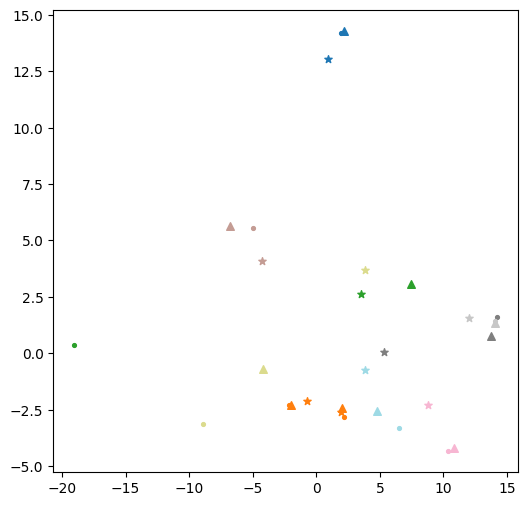

avgpool


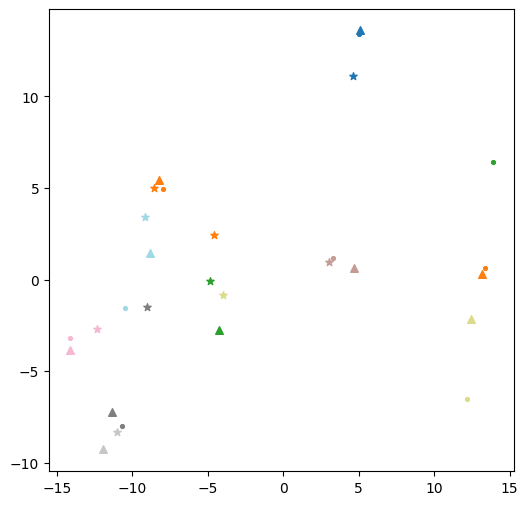

In [81]:
np.random.seed(20)
subset_idx_for_positions_size = 10
subset_idx_for_positions = np.random.choice(np.arange(len(labels)), replace=False, size=subset_idx_for_positions_size)
cmap = matplotlib.cm.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=min(subset_idx_for_positions), vmax=max(subset_idx_for_positions))
S = 30
A = 1
for key in PPG_activations.keys():
    fig = plt.figure(figsize=(6, 6))
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy')
    print(key)    
    for idx in sorted(subset_idx_for_positions):
        color = cmap(norm(idx))
        plt.scatter(X_transformed[:, 0][:labels.shape[0]][idx], X_transformed[:, 1][:labels.shape[0]][idx], color=color, marker='^', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][idx], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][idx], color=color, marker='.', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][2*labels.shape[0]:][idx], X_transformed[:, 1][2*labels.shape[0]:][idx], color=color, marker='*', s=S, alpha=A)
        

    plt.show()

pool0


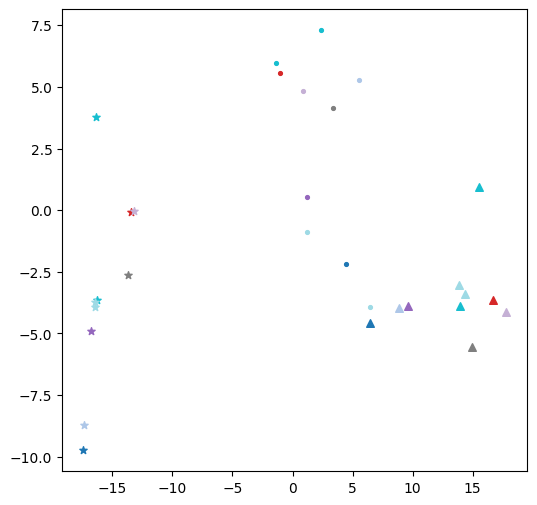

pool1


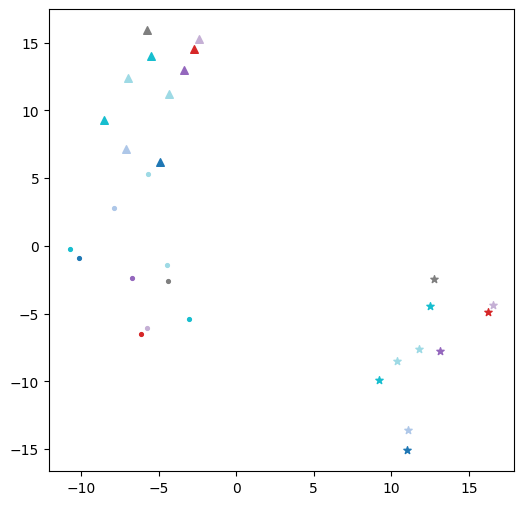

pool2


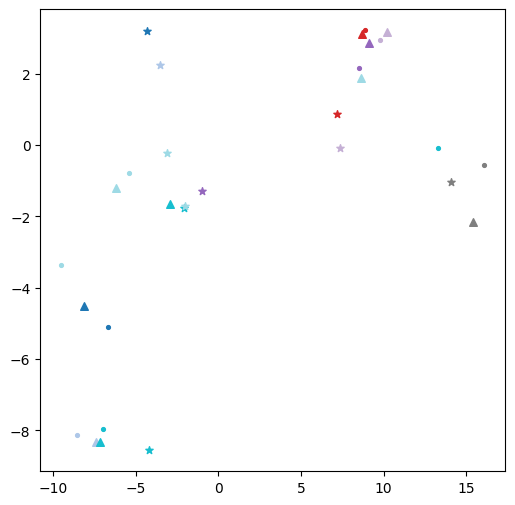

pool3


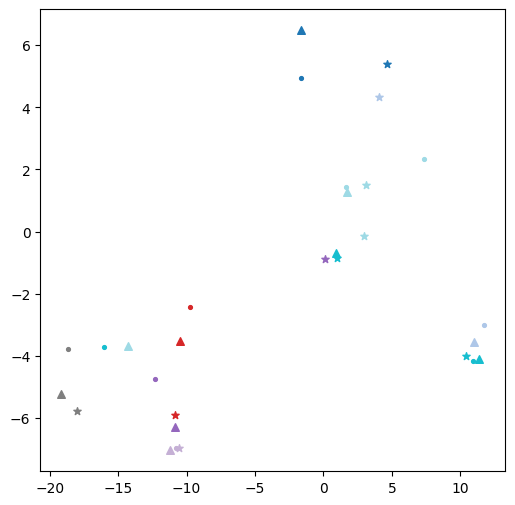

avgpool


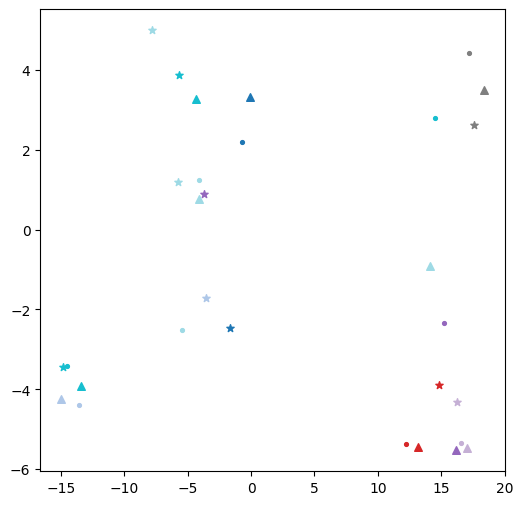

In [83]:
np.random.seed(30)
subset_idx_for_positions_size = 10
subset_idx_for_positions = np.random.choice(np.arange(len(labels)), replace=False, size=subset_idx_for_positions_size)
cmap = matplotlib.cm.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=min(subset_idx_for_positions), vmax=max(subset_idx_for_positions))
S = 30
A = 1
for key in PPG_activations.keys():
    fig = plt.figure(figsize=(6, 6))
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_ppg_peaks.npy')
    print(key)    
    for idx in sorted(subset_idx_for_positions):
        color = cmap(norm(idx))
        plt.scatter(X_transformed[:, 0][:labels.shape[0]][idx], X_transformed[:, 1][:labels.shape[0]][idx], color=color, marker='^', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][labels.shape[0]:2*labels.shape[0]][idx], X_transformed[:, 1][labels.shape[0]:2*labels.shape[0]][idx], color=color, marker='.', s=S, alpha=A)
        plt.scatter(X_transformed[:, 0][2*labels.shape[0]:][idx], X_transformed[:, 1][2*labels.shape[0]:][idx], color=color, marker='*', s=S, alpha=A)
        

    plt.show()

# peaks test set prediction

In [47]:
def test_epoch_peaks(PPG_model, test_loader):
    with torch.no_grad():
       

        PPG_preds = None
        PPG_pred_probs = None
        all_targets = None
        
        PPG_model.eval()
        tstart = datetime.now()

        for batch_idx, (PPG, target) in enumerate(test_loader):

            all_ppg_peaks = []
            for ppg in PPG.cpu().numpy():
            
                PPG_npy = ppg.squeeze()
                rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 240.0)
                wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 240.0)

                PPG_peaks = np.zeros_like(PPG_npy)
                PPG_peaks[wd['peaklist']] = wd['ybeat']
                all_ppg_peaks.append(PPG_peaks.reshape((1, PPG_peaks.shape[0])))
            all_ppg_peaks = np.concatenate(all_ppg_peaks, axis=0)
            PPG_peaks = torch.from_numpy(all_ppg_peaks).float().unsqueeze(1).cuda()
            
            target = target.cuda().long()
            
            _, _, _, _, _, PPG_out = model(PPG_peaks, PPG_peaks)
            
            PPG_predicted = PPG_out.argmax(1)
            PPG_predicted_prob = F.softmax(PPG_out, dim=1)[:, 1]

            if PPG_preds == None:
                PPG_pred_probs = PPG_predicted_prob
                PPG_preds = PPG_predicted
                all_targets = target
            else:
                PPG_preds = torch.cat((PPG_preds, PPG_predicted))
                PPG_pred_probs = torch.cat((PPG_pred_probs, PPG_predicted_prob))
                all_targets = torch.cat((all_targets, target))
        tend = datetime.now()


        print(f'[TEST] \tPPG F1: {f1_score(all_targets.detach().cpu().numpy(), PPG_preds.detach().cpu().numpy())}')
        print(f'[TEST] \tPPG AUC: {roc_auc_score(all_targets.detach().cpu().numpy(), PPG_pred_probs.detach().cpu().numpy())}')



In [46]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128/model_1.pt'
model = Res34SimSiam(512, 128).cuda()
state_dict = torch.load(MODEL_PATH) 
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] #remove 'module'
    new_state_dict[name] = v
    
state_dict = new_state_dict
model.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
test_data_folder = '/labs/hulab/Robust_learning_TESTDATA/'

In [48]:
for f in os.listdir(test_data_folder):
    if '2400' in f:
        
        x_path = test_data_folder + f
        y_path = test_data_folder + 'label_'+'_'.join(f[:-4].split('_')[1:-1]) + '.npy'

        print(f[:-4])
        print(x_path)
        print(y_path)
        test_dataset = Dataset_ori(x_path, y_path)
        testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)

        test_epoch_peaks(model, testloader)

        print()

data_simband_2400
/labs/hulab/Robust_learning_TESTDATA/data_simband_2400.npy
/labs/hulab/Robust_learning_TESTDATA/label_simband.npy
[TEST] 	PPG F1: 0.660217654171705
[TEST] 	PPG AUC: 0.7534663414854459

data_simband_goodquality_2400
/labs/hulab/Robust_learning_TESTDATA/data_simband_goodquality_2400.npy
/labs/hulab/Robust_learning_TESTDATA/label_simband_goodquality.npy
[TEST] 	PPG F1: 0.616822429906542
[TEST] 	PPG AUC: 0.9701619778346122

data_simband_badquality_2400
/labs/hulab/Robust_learning_TESTDATA/data_simband_badquality_2400.npy
/labs/hulab/Robust_learning_TESTDATA/label_simband_badquality.npy
[TEST] 	PPG F1: 0.6666666666666669
[TEST] 	PPG AUC: 0.6951259292324068

data_staford_goodquality_2400
/labs/hulab/Robust_learning_TESTDATA/data_staford_goodquality_2400.npy
/labs/hulab/Robust_learning_TESTDATA/label_staford_goodquality.npy
[TEST] 	PPG F1: 0.581646423751687
[TEST] 	PPG AUC: 0.9496568499106683

data_staford_badquality_2400
/labs/hulab/Robust_learning_TESTDATA/data_staford_bad

In [52]:
stanford_bad_qual = np.load(test_data_folder+'data_staford_badquality_2400.npy')
stanford_good_qual = np.load(test_data_folder+'data_staford_goodquality_2400.npy')
simband_good_qual = np.load(test_data_folder+'data_simband_goodquality_2400.npy')

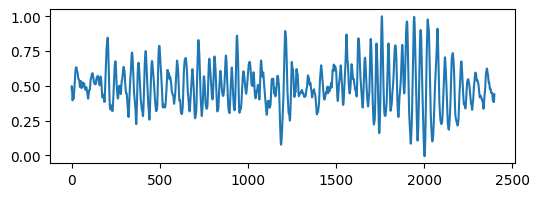

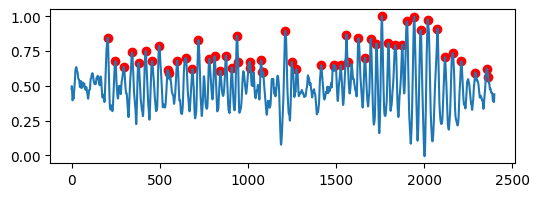

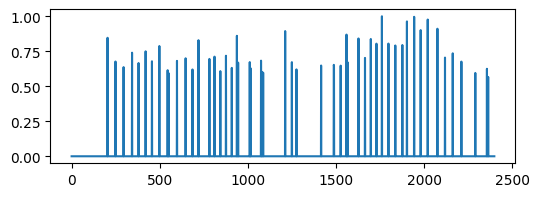

In [10]:
for PPG_npy in stanford_bad_qual:
    rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 240.0)
    wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 240.0)
    
    dummy = np.zeros_like(PPG_npy)
    dummy[wd['peaklist']] = wd['ybeat']
    
    plt.figure(figsize=(6, 2))
    plt.plot(PPG_npy)
    plt.show()
    plt.figure(figsize=(6, 2))
    plt.plot(PPG_npy)
    plt.scatter(wd['peaklist'], wd['ybeat'], c='r')
    plt.figure(figsize=(6, 2))
    plt.plot(dummy)
    
    break

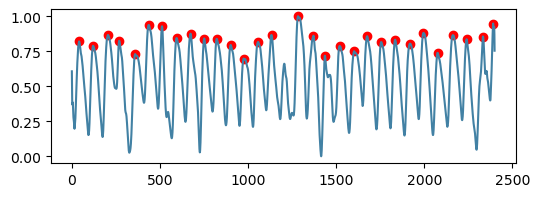

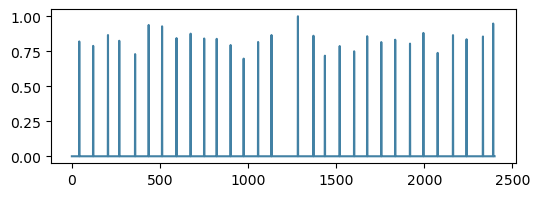

In [63]:
# for PPG_npy in stanford_good_qual:
PPG_npy = stanford_good_qual[2]
rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 240.0)
wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 240.0)

dummy = np.zeros_like(PPG_npy)
dummy[wd['peaklist']] = wd['ybeat']

# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 2))


plt.figure(figsize=(6, 2))
plt.plot(PPG_npy, color='#4281a4')
plt.scatter(wd['peaklist'], wd['ybeat'], c='r')
plt.savefig('ppg_peak_detc.png', dpi=300)

plt.figure(figsize=(6, 2))
# plt.yticks([])
plt.plot(dummy, color='#4281a4')
plt.savefig('binary_peak.png', dpi=300)
#     break

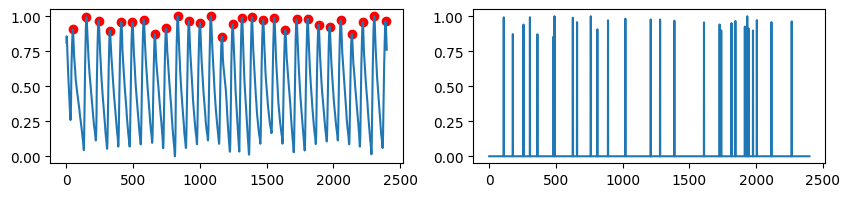

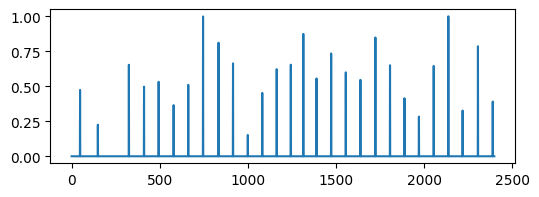

In [27]:
for batch_idx, (ECG, PPG, target) in enumerate(val_loader):
    ECG_npy = ECG.squeeze().cpu().numpy()    
    PPG_npy = PPG[0].squeeze().cpu().numpy()
    
    rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 240.0)
    wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 240.0)
    
    dummy = np.zeros_like(PPG_npy)
    dummy[wd['peaklist']] = wd['ybeat']
    
    random_peaklist = np.random.choice(range(2400), len(wd['peaklist']), replace=False)
    dummy_2 = np.zeros_like(PPG_npy)
    dummy_2[random_peaklist] = wd['ybeat']
    
    random_ybeat = np.random.randn(len(wd['peaklist']))
    random_ybeat = (random_ybeat - random_ybeat.min()) / (random_ybeat.max() - random_ybeat.min())
    dummy_3 = np.zeros_like(PPG_npy)
    dummy_3[wd['peaklist']] = random_ybeat
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 2))

    
    
    ax0.plot(PPG_npy)
    ax0.scatter(wd['peaklist'], wd['ybeat'], c='r')

    ax1.plot(dummy_2)
    
    plt.figure(figsize=(6, 2))
    plt.plot(dummy_3)
    
    
    break